In [1]:
#Custom python file with visualization tools
import visuais as v

#Main Packages
import numpy as np
import pandas as pd
import math
import time
import copy
import random

#Visualizations
from matplotlib import animation
from matplotlib import pyplot as plt
import os
import moviepy
import glob
from moviepy.editor import VideoFileClip, concatenate_videoclips
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from matplotlib.animation import FFMpegWriter

#Statistics packages
from sklearn.cluster import SpectralClustering
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr 
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#Multiprocessing
import multiprocessing as mp
from multiprocessing import Pool

#Others
from ast import literal_eval #Used to convert the dataframe containing PCM transitions
from scipy.optimize import minimize 
from itertools import islice

# Load the Data

In [2]:
# We load the ball dataset separately as a design choice, since it needed to be generated below
def LoadGame(n):
    if n==1: #Ini1
        timeframe1 = 912 #The timeframes indicate the beggining and end of each half
        timeframe2 = 21930
        timeframe3 = 23817
        timeframe4 = 36610 #Final minutes ignored due to bug in tracking data
        field_dim = [50.21011206*2,30.55290322*2] #Manually extracted from the data
        dfhome=pd.read_csv('INI1_eq1_J1.csv',header=None)
        dfaway=pd.read_csv('INI1_eq2_J1.csv',header=None)
        dfcodes=pd.read_csv('F_PB_INI1C.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==2: #Ini2
        timeframe1 = 145
        timeframe2 = 21132
        timeframe3 = 24648
        timeframe4 = 43682
        field_dim = [50.21011206*2,30.55290322*2]
        dfhome=pd.read_csv('INI2_eq2_J1.csv',header=None)
        dfaway=pd.read_csv('INI2_eq1_J1.csv',header=None)
        dfcodes=pd.read_csv('F_PB_INI2.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==3: #Ini3
        timeframe1 = 700
        timeframe2 = 21119
        timeframe3 = 25150
        timeframe4 = 35694
        field_dim = [50.21011206*2,30.55290322*2]
        dfhome=pd.read_csv('INI3_eq1_J1.csv',header=None)
        dfaway=pd.read_csv('INI3_eq2_J1.csv',header=None)
        dfcodes=pd.read_csv('F_PB_INI3.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==4: #Juv2
        timeframe1 = 30492
        timeframe2 = 55227
        timeframe3 = 62176
        timeframe4 = 86598
        field_dim = [49.96530488*2,24.97946377*2]
        dfhome=pd.read_csv('Dia1_eq1_JUV2.csv',header=None)
        dfaway=pd.read_csv('Dia1_eq2_JUV2.csv',header=None)
        dfcodes=pd.read_csv('F_PB_NC_JUV2.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==5: #Juv3
        timeframe1 = 23445
        timeframe2 = 48923
        timeframe3 = 56647
        timeframe4 = 56647 #Second half removed due to bugs in the tracking data
        field_dim = [50.7950451700000016330704966094*2,27.9822253899999999759984348202*2]
        dfhome=pd.read_csv('Dia1_eq1_JUV3.csv',header=None)
        dfaway=pd.read_csv('Dia1_eq2_JUV3.csv',header=None)
        dfcodes=pd.read_csv('F_PB_NC_JUV3.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==6: #Jun2
        timeframe1 = 8152
        timeframe2 = 27184
        timeframe3 = 35908
        timeframe4 = 35908 #Second half removed due to bugs in the tracking data
        field_dim = [51.83099678*2,32.68346768*2]
        dfhome=pd.read_csv('JUN2_eq2.csv',header=None)
        dfaway=pd.read_csv('JUN2_eq1.csv',header=None)
        dfcodes=pd.read_csv('F_PB_JUN2.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes
    elif n==7: #Jun3
        timeframe1 = 27760
        timeframe2 = 51543
        timeframe3 = 54660
        timeframe4 = 78822
        field_dim = [52.66518242*2,30.13992891*2]
        dfhome=pd.read_csv('eq1.xlsx - eq1.csv',header=None)
        dfaway=pd.read_csv('eq2.xlsx - eq2.csv',header=None)
        dfcodes=pd.read_csv('F_PB_JUN3.csv',header=None)
        dfcodes = dfcodes.drop_duplicates()
        return timeframe1, timeframe2, timeframe3, timeframe4, field_dim, dfhome, dfaway, dfcodes

In [3]:
#Choose game to load
Match_index = 7

In [4]:
a, b, c, d, field_dim, dfhome, dfaway, dfcodes = LoadGame(Match_index)

In [5]:
def invert(x): #an inversion is performed for the second half to have both teams attacking to the same side at all times
    return -x
dfawaytemp2 = dfaway.copy() #Dataframes that will be used for the second half
dfhometemp2 = dfhome.copy()
for i in range(2,24):
    dfawaytemp2[i] = dfawaytemp2[i].apply(invert)
    dfhometemp2[i] = dfhometemp2[i].apply(invert)
# First Half home team
dfhome1 = dfhome.iloc[a-2:b+1] #An extra frame was placed at the beginning and end, for the purpose of velocity, will be excluded later
# Second half home team
dfhome2 = dfhometemp2.iloc[c-2:d+1] #An extra frame was placed at the beginning and end, for the purpose of velocity, will be excluded later
# Creates the final dataframe with both halves
dfhome = pd.concat([dfhome1,dfhome2], axis=0)


# Same treatment for the away team
dfaway1 = dfaway.iloc[a-2:b+1] 
dfaway2 = dfawaytemp2.iloc[c-2:d+1]
dfaway = pd.concat([dfaway1,dfaway2], axis=0)


In [6]:
if Match_index == 2 or Match_index == 6: #fixes the fact that teams are flipped in these games
    i=0
    while i < len(dfcodes):
        if dfcodes.iloc[i][1] == 1:
            dfcodes.iloc[i][1] = 2
        elif dfcodes.iloc[i][1] == 2:
            dfcodes.iloc[i][1] = 1
        i += 1

## Creating the ball dataframe

In [7]:
#Placeholder for code to generate the ball dataframe (Not required to run more than once)

In [8]:
#dfball = dfball.reset_index(drop=True)

In [9]:
#dfball.to_csv('dfbJUN2.csv',index = False)

In [10]:
#Load ball dataframe
if Match_index == 1:
    dfball = pd.read_csv('dfbINI1.csv')
elif Match_index == 2:
    dfball = pd.read_csv('dfbINI2.csv')
elif Match_index == 3:
    dfball = pd.read_csv('dfbINI3.csv')
elif Match_index == 4:
    dfball = pd.read_csv('dfbJUV2.csv')
elif Match_index == 5:
    dfball = pd.read_csv('dfbJUV3.csv')
elif Match_index == 6:
    dfball = pd.read_csv('dfbJUN2.csv')
elif Match_index == 7:
    dfball = pd.read_csv('dfbJUN3.csv')

In [11]:
def FrameToIndex(Frame): #A function that receives a frame and outputs the corresponding dataframe index
    return dfball.loc[dfball['Frame']==Frame].index[0]

In [12]:
def IndexToFrame(n): #Reverse of above function
    return dfball.iloc[n,0]

## Create velocity dataframe

In [13]:
num_players = (len(dfaway.columns) - 2) // 2  # We remove the 2 columns that don't correspond to players
velocity_dfaway = dfaway.iloc[:,2:24].diff() #We create a difference dataframe, so velocity will be the difference between consecutive positions
velocity_dfaway = velocity_dfaway.fillna(0)
velocity_dfaway = velocity_dfaway.multiply(10) #Turn velocity into m/s
velocity_dfaway.insert(0, 'Frame', dfaway.iloc[:, 1])
players=[]
for i in range(1,num_players+1):
    players=players+[f'Player {i} X']
    players=players+[f'Player {i} Y']
velocity_dfaway.columns = ['Frame']+players

In [14]:
num_players = (len(dfhome.columns) - 2) // 2  # We remove the 2 columns that don't correspond to players
velocity_dfhome = dfhome.iloc[:,2:24].diff() #We create a difference dataframe, so velocity will be the difference between consecutive positions
velocity_dfhome = velocity_dfhome.fillna(0)
velocity_dfhome = velocity_dfhome.multiply(10) #Turn velocity into m/s
velocity_dfhome.insert(0, 'Frame', dfhome.iloc[:, 1])
players=[]
for i in range(1,num_players+1):
    players=players+[f'Player {i} X']
    players=players+[f'Player {i} Y']
velocity_dfhome.columns = ['Frame']+players

In [15]:
# Similar treatment to obtain  ball velocity
velocity_dfball = dfball.iloc[:,1:3].diff()
velocity_dfball = velocity_dfball.fillna(0)
velocity_dfball = velocity_dfball.multiply(10)
velocity_dfball.insert(0, 'Frame', dfball.iloc[:, 0])

## Create Acceleration dataframe

In [16]:
num_players = (len(dfaway.columns) - 2) // 2  
acc_dfaway = velocity_dfaway.iloc[:,1:23].diff()
acc_dfaway = acc_dfaway.multiply(10) #turn into m/s^2
acc_dfaway.insert(0, 'Frame', dfaway.iloc[:, 1])
store = acc_dfaway['Frame'].iloc[-1] #Storing the last frame to insert back later
acc_dfaway['Frame'] = acc_dfaway['Frame'].shift(1) #shifting the frames down since we want a_n = v_{n+1} - v_n
acc_dfaway = acc_dfaway.shift(-1) #shifting entire dataframe back up to get back to normal
acc_dfaway = acc_dfaway.fillna(0)
acc_dfaway['Frame'].iloc[-1] = store #Restoring the last frame
players=[]
for i in range(1,num_players+1):
    players=players+[f'Player {i} X']
    players=players+[f'Player {i} Y']
acc_dfaway.columns = ['Frame']+players

In [17]:
num_players = (len(dfhome.columns) - 2) // 2  
acc_dfhome = velocity_dfhome.iloc[:,1:23].diff()
acc_dfhome = acc_dfhome.multiply(10) #turn into m/s^2
acc_dfhome.insert(0, 'Frame', dfhome.iloc[:, 1])
store = acc_dfhome['Frame'].iloc[-1] #Storing the last frame to insert back later
acc_dfhome['Frame'] = acc_dfhome['Frame'].shift(1) #shifting the frames down since we want a_n = v_{n+1} - v_n
acc_dfhome = acc_dfhome.shift(-1) #shifting entire dataframe back up to get back to normal
acc_dfhome = acc_dfhome.fillna(0)
acc_dfhome['Frame'].iloc[-1] = store #Restoring the last frame
players=[]
for i in range(1,num_players+1):
    players=players+[f'Player {i} X']
    players=players+[f'Player {i} Y']
acc_dfhome.columns = ['Frame']+players

### Creation of temporary acceleration and velocity dataframes

These serve to simply analyse the max speeds and accelerations that we encounter

In [18]:
#Creation of temporary dataframe with absolute values for the velocity of each player
num_players = (len(dfaway.columns) - 2) // 2 
# Calculating absolute velocity for each player and each frame
player_dist = []
for i in range(num_players):
    x, y = dfaway.iloc[:, 2*i+2], dfaway.iloc[:, 2*i+3]
    dist = np.sqrt((x.diff()**2 + y.diff()**2).fillna(0))
    player_dist.append(dist)
    
# Convert velocities into dataframe and adding player identification
players = [f'Player_{i}' for i in range(1, num_players+1)]
tempvelocity_dfaway = pd.concat(player_dist, axis=1)
tempvelocity_dfaway = tempvelocity_dfaway.multiply(10)
tempvelocity_dfaway.columns = players
tempvelocity_dfaway.insert(0, 'Frame', dfaway.iloc[:, 1])
tempvelocity_dfaway = tempvelocity_dfaway.drop([a-2,b,c-2,d])

In [19]:
#Creation of temporary dataframe with absolute values for the acceleration of each player
num_players = (len(dfaway.columns) - 2) // 2 
# Calculating absolute acceleration for each player and each frame
player_acc = []
for i in range(num_players):
    x, y = velocity_dfaway.iloc[:, 2*i+1], velocity_dfaway.iloc[:, 2*i+2]
    acc = np.sqrt((x.diff()**2 + y.diff()**2).fillna(0))
    player_acc.append(acc)
    
# Convert accelerations into dataframe and adding player identification
players = [f'Player_{i}' for i in range(1, num_players+1)]
tempacc_dfaway = pd.concat(player_acc, axis=1)
tempacc_dfaway = tempacc_dfaway.multiply(10)
tempacc_dfaway.columns = players
tempacc_dfaway.insert(0, 'Frame', dfaway.iloc[:, 1])
store = tempacc_dfaway['Frame'].iloc[-1] #Storing the last frame to insert back later
tempacc_dfaway['Frame'] = tempacc_dfaway['Frame'].shift(1) #shifting the frames down since we want a_n = v_{n+1} - v_n
tempacc_dfaway = tempacc_dfaway.shift(-1) #shifting entire dataframe back up to get back to normal
tempacc_dfaway = tempacc_dfaway.fillna(0)
tempacc_dfaway['Frame'].iloc[-1] = store #Restoring the last frame
tempacc_dfaway = tempacc_dfaway.drop([a-2,b,c-2,d])

In [20]:
#Checking maximum velocities and accelerations for a given player, will give an idea of the maximum velocity and acceleration parameters for the PCM
#We look at the 30 highest results to account for possible inconsistencies in the tracking data
tempacc_dfaway.Player_1.nlargest(30)

50280    5.961543
50279    5.948109
50278    5.916925
50277    5.852350
59146    5.656854
50281    5.646238
59144    5.643580
33290    5.641640
33291    5.565932
50276    5.531727
33289    5.526672
59145    5.458938
28333    5.350037
59143    5.333854
28332    5.307391
50275    5.303772
67144    5.285558
50282    5.281098
33292    5.278219
59147    5.261179
67145    5.224496
28334    5.221532
33288    5.221197
67143    5.216835
28335    5.206006
59148    5.197115
67124    5.056679
67142    5.055989
59142    5.035871
50283    5.032892
Name: Player_1, dtype: float64

#### Dropping extra frames

Dropping the extra frames created for velocity and acceleration, required to run

In [21]:
#Dropping the extra frames
dfaway = dfaway.drop([a-2,b,c-2,d]).reset_index(drop=True)
velocity_dfaway = velocity_dfaway.drop([a-2,b,c-2,d]).reset_index(drop=True)
acc_dfaway = acc_dfaway.drop([a-2,b,c-2,d]).reset_index(drop=True)
dfhome = dfhome.drop([a-2,b,c-2,d]).reset_index(drop=True)
velocity_dfhome = velocity_dfhome.drop([a-2,b,c-2,d]).reset_index(drop=True)
acc_dfhome = acc_dfhome.drop([a-2,b,c-2,d]).reset_index(drop=True)
velocity_dfball = velocity_dfball.drop([FrameToIndex(a-1),FrameToIndex(b+1),FrameToIndex(c-1),FrameToIndex(d+1)]).reset_index(drop=True)
dfball = dfball.drop([FrameToIndex(a-1),FrameToIndex(b+1),FrameToIndex(c-1),FrameToIndex(d+1)]).reset_index(drop=True)

## Creating possession list

We aim to create a list of possessions per team, with start and end frame as well as the terminal state of the possession

In [22]:
pos=[] #List in which possessions will be stored
EndsInPossession = False #Flag that indicates if a game ended with a team in possession
i=0
l=len(dfcodes)
while i<l:
    while i < l-1 and dfcodes[0].iloc[i] == dfcodes[0].iloc[i+1]: #skip repeated frames
        i += 1
    temp = [dfcodes[0].iloc[i]] #Storing the frame
    Team = dfcodes[1].iloc[i] #Storing team in possession
    if Team > 2: #Covers for a special case in which skipping a frame leads to an event, meaning there was a single frame possession by a team
        temp += [temp[0],dfcodes[1].iloc[i-1],True] #last element is a SingleTouchFlag, to use later
        pos += [temp]
        i += 1
    else:
        SingleTouchFlag = False #Used later to determine final result of possession and differentiate turnovers from deflections from the opponent
        oldi = i
        while i < l and dfcodes[1].iloc[i] == Team:
            i += 1
        if i - oldi == 1: #This would imply that there was a single touch possession, which we'll qualify as a deflection
            SingleTouchFlag = True 
        if i == l: #covers the case of last possession of the game
            temp += [dfcodes[0].iloc[i-1],Team,SingleTouchFlag]
            pos += [temp]
            EndsInPossession = True #Flag that indicates if a game ended with a team in possession
        else:
            temp += [dfcodes[0].iloc[i]-1,Team,SingleTouchFlag]
            pos += [temp]
            while i < l and dfcodes[1].iloc[i] > 2:
                i += 1
### Populating the list with the final results of each possession ###
#Creating a list of the final frames of each possession, to search later
FinalFrameList = []
for i in range(len(pos)):
    if pos[i][0] == pos[i][1] or (EndsInPossession and i == len(pos)-1):
        if len(dfcodes.loc[dfcodes[0] == pos[i][0] + 1][1].tolist()) == 1: #Fix for single frame possessions
            FinalFrameList += [pos[i][1]+1]
        else:
            FinalFrameList += [pos[i][1]]
    else:
        FinalFrameList += [pos[i][1]+1]
i = len(pos) - 1
l = 0
while i >= l: #We work backwards to facilitate the creation of the OutKept final result
    FinalFrame = FinalFrameList[i]
    if i > 0 and FinalFrame == FinalFrameList[i-1]: #Single frame case, taking the second line of dfcodes
        if i != len(pos)-1:
            code = dfcodes.loc[dfcodes[0] == FinalFrame][1].tolist()[1]
            code2 = dfcodes.loc[dfcodes[0] == FinalFrame][2].tolist()[1]
        else:
            code = dfcodes.loc[dfcodes[0] == FinalFrame][1].tolist()[0]
            code2 = dfcodes.loc[dfcodes[0] == FinalFrame][2].tolist()[0]
    else:
        code = dfcodes.loc[dfcodes[0] == FinalFrame][1].tolist()[0]
        code2 = dfcodes.loc[dfcodes[0] == FinalFrame][2].tolist()[0]
    if (EndsInPossession and i == len(pos)-1): #Serves for occasions where the game ends during a possession 
        pos[i] += ['GameEnd']                  #this never happened for half-time in this dataset, so that case was not covered
    else:
        if code == 3:
            pos[i] += ['OutThrow']
        if code == 4:
            if (code2 < 4 and pos[i][2] == 1) or (code2 > 3 and pos[i][2] == 2):
                pos[i] += ['OutCorner']
            else:
                pos[i] += ['OutGK']
        elif code == 6:
            pos[i] += ['Goal']
        elif code == 7:
            pos[i] += ['Foul']
        elif code == 1 or code == 2: #If there was a turnover but it was a single touch possession that went out, we consider it a deflection and classify it as Outkept, meaning the team did not truly lose the ball
            if (pos[i+1][-1] == 'OutThrow' or pos[i+1][-1] == 'OutCorner' or pos[i+1][-1] == 'OutGK') and pos[i+1][-2]:
                pos[i] += ['OutKept']
            else:
                pos[i] += ['Turnover']
    i -= 1
i = len(pos)-2
while i >= 0: #Deleting possessions immediately following a ball out or a foul, as we want to remove set pieces from the dataset
    if (pos[i][-1] == 'OutCorner' or pos[i][-1] == 'OutThrow' or pos[i][-1] == 'OutGK' or pos[i][-1] == 'Foul'):
        del pos[i+1]
    i -= 1
specialpos = copy.deepcopy(pos) #keeps single touch possessions, will be necessary for model validation of the PCM
i = 0
while i < len(pos): #Delete single touch possessions and flag
    if pos[i][3] == True:
        del pos[i]
    else:
        del pos[i][3]
        i += 1
i = 0
while i < len(specialpos):
    del specialpos[i][3]
    i += 1
poslist =[] #Creates a by frame list of possession state
for i in pos:
    for j in range(i[0],i[1]+1):
        poslist += [[j,i[2]]]
    poslist += [i[-1]]
specialposlist =[] #Creates a by frame list of possession state for the specialpos
for i in specialpos:
    for j in range(i[0],i[1]+1):
        specialposlist += [[j,i[2]]]
    specialposlist += [i[-1]]

In [23]:
def FrameToTeam(Frame): #For a given frame, outputs the team in possession, used later
    for i in poslist:
        if not isinstance(i,str):
            if i[0] == Frame:
                return i[1]
    return 0 #If there's no team in possession (that is, the game is stopped)

### Possession by player

We want a similar list of possessions, but broken down by player instead

In [24]:
### Similar to code above, but breaks down possession on a player by player basis###
PlayerPos = [] 
i = 0
l=len(dfcodes)
while i<l:
    while i < l-1 and dfcodes[0].iloc[i] == dfcodes[0].iloc[i+1]: #skip repeated frames
        i += 1
    temp = [dfcodes[0].iloc[i]]
    Team = dfcodes[1].iloc[i]
    p = dfcodes[2].iloc[i]
    if Team > 2: #Covers for a special case in which skipping a frame leads to an event, meaning there was a single frame possession by a team
        temp += [temp[0],dfcodes[1].iloc[i-1],dfcodes[2].iloc[i-1]]
        PlayerPos += [temp]
        i += 1
    else:
        while i < l and dfcodes[1].iloc[i] == Team and dfcodes[2].iloc[i] == p:
            i += 1
        if i == l: #covers for last possession of the game
            temp += [dfcodes[0].iloc[i-1],Team,p]
            PlayerPos += [temp]
        else:
            temp += [dfcodes[0].iloc[i-1],Team,p]
            PlayerPos += [temp]
            temp = [dfcodes[0].iloc[i-1]+1,dfcodes[0].iloc[i]-1,Team,0] #Creates a possession with assigned team but no player, ball is in flight
            PlayerPos += [temp]
            while i < l and dfcodes[1].iloc[i] > 2:
                i += 1
l = len(PlayerPos)
i = 0
while i < l: #Solving special case
    if PlayerPos[i][0] > PlayerPos[i][1]:
        del PlayerPos[i]
        l -= 1
    i += 1
l = len(PlayerPos)
i = 0
while i < l-1: #Solving special case
    if PlayerPos[i][1] == PlayerPos[i+1][0]:
        PlayerPos[i][1] -= 1
    i += 1
PlayerPoslist =[] #Creating a frame by frame possession list, with final outcomes
for i in PlayerPos:
    for j in range(i[0],i[1]+1):
        PlayerPoslist += [[j,i[2],i[3]]]
SpecialPlayerPoslist = copy.deepcopy(PlayerPoslist)
i = 0
while i < len(PlayerPoslist): #Delete frames to match Poslist
    if not FrameToTeam(PlayerPoslist[i][0]):
        del PlayerPoslist[i]
    else:
        i += 1
i = 0
while i < len(PlayerPoslist): #Include final outcomes from poslist
    if not isinstance(poslist[i],str):
        if PlayerPoslist[i][0] != poslist[i][0]:
            del PlayerPoslist[i]
        else:
            i += 1
    else:
        PlayerPoslist.insert(i,poslist[i])
        i += 1
PlayerPoslist += [poslist[-1]] #Add final string
res = copy.deepcopy(SpecialPlayerPoslist)
i = 0
Flag = True
while i < len(SpecialPlayerPoslist): #Do the same for the special case
    if i < len(specialposlist) and not isinstance(specialposlist[i],str):
        if SpecialPlayerPoslist[i][0] != specialposlist[i][0]:
            del SpecialPlayerPoslist[i]
        else:
            i += 1
    elif i < len(specialposlist):
        SpecialPlayerPoslist.insert(i,specialposlist[i])
        i += 1
    else: #Handling case where last possession is deleted
        del SpecialPlayerPoslist[i]
        Flag = False
if Flag:
    SpecialPlayerPoslist += [specialposlist[-1]] #Add final string

In [25]:
def FrameToPlayer(Frame): #For a given frame, outputs the player in possession, used later
    for i in PlayerPoslist:
        if not isinstance(i,str):
            if i[0] == Frame:
                return [i[1],i[2]]
    return 0 #If there's no player in possession

# Pitch Control Model

Pitch control model based on the work of Spearman (2017), later updated in 2018 in the paper "Beyond Expected goals". This implementation heavily borrows from the work of Laurie Shaw found here: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

In [26]:
#Parameter Definition
MaxVelocity = 7
MaxAcceleration = 4
BallSpeed = 15
dt = 0.04
max_int = 10
conv_tol = 0.01
OffsideTolerance = 0.5 
########################################################

In [27]:
def initPCM(n,Team, lamb = 4.925, k = 1.048): #Function that initializes player and ball positions for the PCM model, for index n
    AttPlayers = [] #List that will store all attacking players
    DefPlayers = [] #List that will store all defensive players
    lambd = k*lamb
    lambg = 3*lambd
    BallPosition = [dfball.iloc[n,1],dfball.iloc[n,2]] #Determine Ball Position
    if Team==1:
        for i in range(1,12): #For each player registers position and velocity
            AttPlayers = AttPlayers +[[dfhome.iloc[n,2*i],dfhome.iloc[n,2*i+1],velocity_dfhome.iloc[n,2*i-1],velocity_dfhome.iloc[n,2*i]]]
            DefPlayers = DefPlayers +[[dfaway.iloc[n,2*i],dfaway.iloc[n,2*i+1],velocity_dfaway.iloc[n,2*i-1],velocity_dfaway.iloc[n,2*i]]]
    else:
        for i in range(1,12):
            DefPlayers = DefPlayers +[[dfhome.iloc[n,2*i],dfhome.iloc[n,2*i+1],velocity_dfhome.iloc[n,2*i-1],velocity_dfhome.iloc[n,2*i]]]
            AttPlayers = AttPlayers +[[dfaway.iloc[n,2*i],dfaway.iloc[n,2*i+1],velocity_dfaway.iloc[n,2*i-1],velocity_dfaway.iloc[n,2*i]]]
    i=0
    while i < 11: #initialize lambdas, pcf and tti for later use
        AttPlayers[i] = AttPlayers[i] + [lamb, 0, 0]
        i += 1
    DefPlayers[0] = DefPlayers[0] + [lambg, 0, 0] #Goalkeeper gets special lambda value
    i = 1
    while i < 11:
        DefPlayers[i] = DefPlayers[i] + [lambd,0, 0]
        i += 1
    return AttPlayers,DefPlayers,BallPosition

In [28]:
def checkoffsides(AttPlayers,DefPlayers,BallPosition,Team,tol): #removes attacking players for being offside, given some tolerance
    if Team==1:
        xlist = []
        for i in DefPlayers:
            xlist += [i[0]]
        xlist.sort()
        lim = max(xlist[-2],0,BallPosition[0]) #offside limit
        AttPlayers = [i for i in AttPlayers if i[0] < lim + tol]
        return AttPlayers
    if Team==2:
        xlist = []
        for i in DefPlayers:
            xlist += [i[0]]
        xlist.sort()
        lim = min(xlist[1],0,BallPosition[0])
        AttPlayers = [i for i in AttPlayers if i[0] > lim - tol]
        return AttPlayers
        

In [29]:
def IntegrateVelocity(d,InitialVelocity,MaxVelocity,acc): #Given a distance d, initial velocity, max velocity and acceleration, outputs time to reach target
    if InitialVelocity >= MaxVelocity:
        return d/MaxVelocity
    T0 = (MaxVelocity-InitialVelocity)/acc #Time to reach max speed
    d0 = InitialVelocity*T0 + (acc/2)*(T0**2) #Distance covered during acceleration phase
    if d0 > d: #Case where the target is reached during acceleration phase
        return (-InitialVelocity + np.sqrt(InitialVelocity**2 +2*acc*d))/acc
    else: #Case where target is only reached past the accelerating phase
        return (d-d0)/MaxVelocity + T0

In [30]:
def TimeToIntercept(PlayerPosition,PlayerVelocity,TargetPosition,MaxAcceleration,MaxVelocity,ReactionTime,model): 
    #Given a player current position, a target position, current velocity, max acceleration and velocity and reaction time
    #Outputs expected time to intercept.
    #Model = 0 is our implementation with the trained parameters
    #Model = 1 is Shaw's implementation with trained parameters
    #Model = 2 is our implementation with custom parameters
    #Model = 3 is Shaw's implementation with custom parameters
    if not model%2: #Our model, implements our method
        ReactionPosition = [PlayerPosition[0] + PlayerVelocity[0]*ReactionTime,PlayerPosition[1] + PlayerVelocity[1]*ReactionTime] #Position after reaction time
        DistanceVector = [TargetPosition[0]-ReactionPosition[0],TargetPosition[1]-ReactionPosition[1]]
        Distance = np.sqrt(DistanceVector[0]**2 + DistanceVector[1]**2) #Total distance to cover after reaction time
        if Distance == 0:
            return ReactionTime
        InitialVelocity = (PlayerVelocity[0]*DistanceVector[0]+PlayerVelocity[1]*DistanceVector[1])/Distance #Projects the vector onto the distance vector to obtain a InitialVelocity
        return ReactionTime + IntegrateVelocity(Distance,InitialVelocity,MaxVelocity,MaxAcceleration)
    else: #Shaw's model, implements Shaw's method
        ReactionPosition = [PlayerPosition[0] + PlayerVelocity[0]*ReactionTime,PlayerPosition[1] + PlayerVelocity[1]*ReactionTime]
        DistanceVector = [TargetPosition[0]-ReactionPosition[0],TargetPosition[1]-ReactionPosition[1]]
        Distance = np.sqrt(DistanceVector[0]**2 + DistanceVector[1]**2)
        if Distance == 0:
            return ReactionTime
        return ReactionTime + Distance/MaxVelocity

In [31]:
def probability_intercept_ball(T,s,exp):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/s * (T-exp) ) )
        return f

In [32]:
def pcm_at_target(TargetPosition,AttPlayers,DefPlayers,BallPosition,model = 0, s = 0.233, lamb = 5.793, lambd = 5.793, lambg = 17.379, ttca = 2.0797991363203825, ttcd = 2.0797991363203825, ReactionTime = 0.2):
    #Given a target position, the information of the ball and players, gives out the value of the PCM
    ############################################################
    if ((TargetPosition[0] > -34 and TargetPosition[0] < 34) or TargetPosition[1] > 20 or TargetPosition[1] < -20):
        #Checking if we're inside one of the boxes to update goalkeeper lambda (doesn't check if it's the defensive box)
        DefPlayers[0][4] = lambd
    i=0
    while i < 11: #Initializes ppcf and time to intercept (overrides what's done in initPCM)
        DefPlayers[i][5] = 0
        DefPlayers[i][6] = TimeToIntercept([DefPlayers[i][0],DefPlayers[i][1]],[DefPlayers[i][2],DefPlayers[i][3]],TargetPosition,MaxAcceleration,MaxVelocity,ReactionTime,model)
        i += 1
    i=0
    while i < len(AttPlayers): #Initializes ppcf and time to intercept, being careful to account for the potential of offside attackers
        AttPlayers[i][5] = 0
        AttPlayers[i][6] = TimeToIntercept([AttPlayers[i][0],AttPlayers[i][1]],[AttPlayers[i][2],AttPlayers[i][3]],TargetPosition,MaxAcceleration,MaxVelocity,ReactionTime,model)
        i += 1
    # ball travel time is distance to target position from current ball position divided by assumed average ball speed
    ball_travel_time = np.sqrt((TargetPosition[0]-BallPosition[0])**2 + (TargetPosition[1]-BallPosition[1])**2)/BallSpeed

    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p[6] for p in AttPlayers] )
    tau_min_def = np.nanmin( [p[6] for p in DefPlayers] )

    # check whether we actually need to solve differential equation
    if tau_min_att-max(ball_travel_time,tau_min_def) >= ttcd:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= ttca:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in AttPlayers if p[6]-tau_min_att < ttca ]
        defending_players = [p for p in DefPlayers if p[6]-tau_min_def < ttcd ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-dt, ball_travel_time + max_int, dt) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit
        ptot = 0.0
        i = 1
        while 1-ptot>conv_tol and i<dT_array.size: 
            T = dT_array[i]
            for p in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*probability_intercept_ball(T,s,p[6]) * p[4]
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                p[5] += dPPCFdT*dt # total contribution from individual player
                PPCFatt[i] += p[5] # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for p in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*probability_intercept_ball(T,s,p[6]) * p[4]
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                p[5] += dPPCFdT*dt # total contribution from individual player
                PPCFdef[i] += p[5] # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return min(PPCFatt[i-1]/ptot,1.), min(PPCFdef[i-1]/ptot,1) #Make them add up to 1

In [ ]:
dt = 0.04
max_int = 10
conv_tol = 0.01

In [33]:
def RunLine(l):
    #Auxiliary function to allow multiprocessing in the main PCM function. Only used when generating a single PCM
    i, xgrid, ygrid, AttPlayers, DefPlayers, BallPosition, model, s, lamb, lambd, lambg, ttca, ttcd, ReactionTime = l[0], l[1], l[2], l[3], l[4], l[5], l[6], l[7], l[8], l[9], l[10], l[11], l[12], l[13]
    outputa = []
    outputd = []
    for j in range( len(xgrid) ):
        TargetPosition = [xgrid[j], ygrid[i]]
        res = pcm_at_target(TargetPosition,AttPlayers,DefPlayers,BallPosition,model, s, lamb, lambd, lambg, ttca, ttcd, ReactionTime)
        outputa += [[res[0]]]
        outputd += [[res[1]]]
    return [outputa, outputd]

def generate_PCM(n, mp = False, model = 0, params = None):
    Frame = IndexToFrame(n)
    Team = FrameToTeam(Frame)
    if not model%2: #Check if our model
        #Parameters
        ReactionTime = 0.2
        ########################################################
    else:
        #Parameters (Shaw)
        ReactionTime = 0.7
        ########################################################
    if model == 0:
        s = 0.462 
        lamb = 4.925 
        k = 1.048 
        lambd = k*lamb
        lambg = 3*lambd
    elif model == 1:
        s = 0.353
        lamb = 5.035
        k = 1.039
        lambd = k*lamb
        lambg = 3*lambd
    else:
        s = params[0]
        lamb = params[1]
        k = params[2]
        lambd = k*lamb
        lambg = 3*lambd
    ttca = 3*np.log(10) * (np.sqrt(3)*s/np.pi + 1/lamb)
    ttcd = 3*np.log(10) * (np.sqrt(3)*s/np.pi + 1/lambd)
    AttPlayers, DefPlayers, BallPosition = initPCM(n,Team,lamb,k)
    # break the pitch down into a grid
    n_grid_cells_x = 100
    n_grid_cells_y = 60
    dx = field_dim[0]/n_grid_cells_x
    dy = field_dim[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dim[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dim[1]/2. + dy/2.
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # find any attacking players that are offside and remove them from the pitch control calculation
    AttPlayers = checkoffsides(AttPlayers,DefPlayers,BallPosition,Team,OffsideTolerance)
    # calculate potential pitch control model at each location on the pitch
    if mp: #multiprocessing, only used if function is called once. If called multiple times, mp is done externally
        inputs = []
        for i in range(len(ygrid)):
            inputs += [[i,xgrid,ygrid,AttPlayers,DefPlayers,BallPosition,model, s, lamb, lambd, lambg, ttca, ttcd, ReactionTime]]
        with Pool() as pool:
            results = pool.map(RunLine,inputs)
        for i in range( len(ygrid) ):
            for j in range( len(xgrid) ):
                PPCFa[i,j] = results[i][0][j][0]
                PPCFd[i,j] = results[i][1][j][0]
    else:
        for i in range( len(ygrid) ):
            for j in range( len(xgrid) ):
                TargetPosition = [xgrid[j], ygrid[i]]
                PPCFa[i,j],PPCFd[i,j] = pcm_at_target(TargetPosition,AttPlayers,DefPlayers,BallPosition,model, s, lamb, lambd, lambg, ttca, ttcd, ReactionTime)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < 0.01, "Checksum failed: %1.3f %1.0f" % (1-checksum,n)
    return PPCFd,xgrid,ygrid

In [34]:
def plot_PCM(dfhome, dfaway, dfb, dist_dfhome, dist_dfaway, Frame, PPCF, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (100.0,60)):
    Frame2 = IndexToFrame(Frame)
    Team = FrameToTeam(Frame2)
    awayteam = dfaway[Frame:Frame+1]
    hometeam = dfhome[Frame:Frame+1]
    vhometeam = dist_dfhome[Frame:Frame+1]
    vawayteam = dist_dfaway[Frame:Frame+1]
    ball = dfb[Frame:Frame+1].values.tolist()[0]
    
    # plot frame and event
    fig,ax = v.plot_pitch(field_color='white', field_dimen = field_dimen)
    v.plot_frame( hometeam, awayteam, ball, vhometeam, vawayteam, figax=(fig,ax), team_colors=('b','r'), field_dimen = field_dimen, include_player_velocities=include_player_velocities, PlayerMarkerSize=10, PlayerAlpha=alpha, annotate=annotate)   
    # plot pitch control surface
    if Team==1:
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)

    return fig,ax


Example of a PCM plot

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

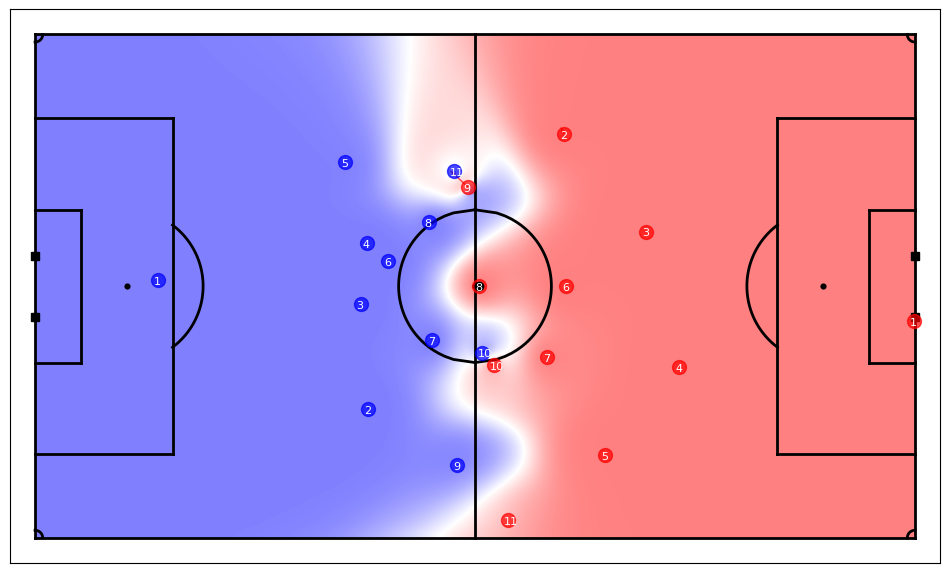

In [35]:
PPCF = generate_PCM(0,mp = True, model = 0)[0]
plot_PCM(dfhome,dfaway,dfball,velocity_dfhome,velocity_dfaway,0,PPCF,annotate=True, field_dimen = field_dim)

## Parameter Estimation

Estimating the optimal parameters for the PCM model

In [36]:
#Version of the PCM implementation that will be used to train the parameters
def pcm_at_target_train(TargetPosition,AttPlayers,DefPlayers,BallPosition,model = 0, params = None):
    #Given a target position, the information of the ball and players, gives out the value of the PCM
    if not model%2: #Check if our model
        #Parameters
        ReactionTime = 0.2
        ########################################################
    else:
        #Parameters (Shaw)
        ReactionTime = 0.7
        ########################################################
    if model == 0:
        s = 0.462 #0.54
        lamb = 4.925 #3.99
        k = 1.048 # 1.72
        lambd = k*lamb
        lambg = 3*lambd
    elif model == 1:
        s = 0.353
        lamb = 5.035
        k = 1.039
        lambd = k*lamb
        lambg = 3*lambd
    else:
        s = params[0]
        lamb = params[1]
        k = params[2]
        lambd = k*lamb
        lambg = 3*lambd
    ttca = 3*np.log(10) * (np.sqrt(3)*s/np.pi + 1/lamb)
    ttcd = 3*np.log(10) * (np.sqrt(3)*s/np.pi + 1/lambd)
    ############################################################
    if ((TargetPosition[0] > -34 and TargetPosition[0] < 34) or TargetPosition[1] > 20 or TargetPosition[1] < -20):
        #Checking if we're inside one of the boxes to update goalkeeper lambda (doesn't check if it's the defensive box)
        DefPlayers[0][4] = lambd
    else:
        DefPlayers[0][4] = lambg
    i = 1
    #Update lambdas
    while i < 11:
        DefPlayers[i][4] = lambd
        i += 1
    for j in AttPlayers:
        j[4] = lamb
    i=0
    while i < 11: #Initializes ppcf and time to intercept
        DefPlayers[i][5] = 0
        DefPlayers[i][6] = TimeToIntercept([DefPlayers[i][0],DefPlayers[i][1]],[DefPlayers[i][2],DefPlayers[i][3]],TargetPosition,MaxAcceleration,MaxVelocity,ReactionTime,model)
        i += 1
    i=0
    while i < len(AttPlayers): #Initializes ppcf and time to intercept, being careful to account for the potential of offside attackers
        AttPlayers[i][5] = 0
        AttPlayers[i][6] = TimeToIntercept([AttPlayers[i][0],AttPlayers[i][1]],[AttPlayers[i][2],AttPlayers[i][3]],TargetPosition,MaxAcceleration,MaxVelocity,ReactionTime,model)
        i += 1
    # ball travel time is distance to target position from current ball position divided assumed average ball speed
    ball_travel_time = np.sqrt((TargetPosition[0]-BallPosition[0])**2 + (TargetPosition[1]-BallPosition[1])**2)/BallSpeed

    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p[6] for p in AttPlayers] )
    tau_min_def = np.nanmin( [p[6] for p in DefPlayers] )

    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= ttcd:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= ttca:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in AttPlayers if p[6]-tau_min_att < ttca ]
        defending_players = [p for p in DefPlayers if p[6]-tau_min_def < ttcd ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-dt, ball_travel_time + max_int, dt) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>conv_tol and i<dT_array.size: 
            T = dT_array[i]
            for p in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*probability_intercept_ball(T,s,p[6]) * p[4]
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                p[5] += dPPCFdT*dt # total contribution from individual player
                PPCFatt[i] += p[5] # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for p in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*probability_intercept_ball(T,s,p[6]) * p[4]
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                p[5] += dPPCFdT*dt # total contribution from individual player
                PPCFdef[i] += p[5] # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return min(PPCFatt[i-1]/ptot,1.), min(PPCFdef[i-1]/ptot,1)

Creating a dataset of the ball transitions that concern the PCM

In [37]:
#Creates a list of every single ball transition
#Auxiliary function that adds single transition
def AddTransition1(Player1,Player2,Transitions):
    InitFrame = Player1[0] #Frame where pass begins
    Team = Player1[1] #Team executing the pass
    AttPlayers,DefPlayers,BallPosition = initPCM(FrameToIndex(InitFrame),Team, 0, 0) #Game information
    FinalFrame = Player2[0] #Frame where pass is received
    PlayerID = [Player2[1],Player2[2]] #Team and player receiving the pass
    SuccessFlag = Player2[3] #Whether the pass was successful
    if SuccessFlag: #Check controlled touch
        for j in range(FinalFrame,FinalFrame + 21): #Check if team stays in possession for 2 full seconds (To be considered controlled touch)
            if FrameToTeam(j) != Team:
                SuccessFlag = 0
                break
    if PlayerID[0] == 1: 
        X = dfhome[2*PlayerID[1]].loc[FrameToIndex(FinalFrame)]
        Y = dfhome[2*PlayerID[1]+1].loc[FrameToIndex(FinalFrame)]
        return Transitions + [(InitFrame,[X,Y],AttPlayers,DefPlayers,BallPosition,SuccessFlag)]
    else:
        X = dfaway[2*PlayerID[1]].loc[FrameToIndex(FinalFrame)]
        Y = dfaway[2*PlayerID[1]+1].loc[FrameToIndex(FinalFrame)]
        return Transitions + [(InitFrame,[X,Y],AttPlayers,DefPlayers,BallPosition,SuccessFlag)]
def PCM_transitions1():
    i = 0
    Transitions = []
    while i < len(PlayerPoslist):
        Player = [PlayerPoslist[i][1],PlayerPoslist[i][2]] #Player executing pass (assumes play always resumes with a player controlling the ball)
        while not isinstance(PlayerPoslist[i],str) and PlayerPoslist[i][2] == Player[1] and PlayerPoslist[i][1] == Player[0]:
            #While nothing changes, do nothing
            i += 1
        if isinstance(PlayerPoslist[i],str):
            if PlayerPoslist[i] == 'Turnover':
                #Indicates the pass failed, saves player that received the pass and adds the transition with a success flag of 0
                Player1 = [PlayerPoslist[i-1][0]] + Player #saves frame of pass
                i += 1
                if i == len(PlayerPoslist):
                    break
                #Handling special case where turnover happens into a single touch possession that was deleted
                FrameOfReception = PlayerPoslist[i-2][0] + 1
                for j in SpecialPlayerPoslist:
                    if not isinstance(j,str):
                        if j[0] == FrameOfReception:
                            Player2 = [FrameOfReception,j[1],j[2],0]
                Transitions = AddTransition1(Player1,Player2,Transitions)
            else:
                #For our purposes, the transition never happened
                i += 1
                if i == len(PlayerPoslist):
                    break
        elif PlayerPoslist[i][2] != 0: #if pass immediately goes to another player, without flight time for the ball
            #Indicates the pass succeeded, saves player that received the pass and adds the transition with a success flag of 1
            Player1 = [PlayerPoslist[i-1][0]] + Player #saves frame of pass
            Player2 = [PlayerPoslist[i][0],PlayerPoslist[i][1],PlayerPoslist[i][2],1]
            Transitions = AddTransition1(Player1,Player2,Transitions)
        else:
            Player1 = [PlayerPoslist[i-1][0]] + Player #saves frame of pass
            while not isinstance(PlayerPoslist[i],str) and PlayerPoslist[i][2] == 0: #skips over flight time of the ball
                i += 1
                if i == len(PlayerPoslist):
                    break
            if isinstance(PlayerPoslist[i],str):
                if PlayerPoslist[i] == 'Turnover':
                    #Indicates the pass failed, saves player that received the pass and adds the transition with a success flag of 0
                    i += 1
                    if i == len(PlayerPoslist):
                        break
                    #Handling special case where turnover happens into a single touch possession that was deleted
                    FrameOfReception = PlayerPoslist[i-2][0] + 1
                    for j in SpecialPlayerPoslist:
                        if not isinstance(j,str):
                            if j[0] == FrameOfReception:
                                Player2 = [FrameOfReception,j[1],j[2],0]
                    Transitions = AddTransition1(Player1,Player2,Transitions)
                else:
                    #For our purposes, the transition never happened
                    i += 1
                    if i == len(PlayerPoslist):
                        break
            else:
                #Indicates the pass succeeded, saves player that received the pass and adds the transition with a success flag of 1
                Player2 = [PlayerPoslist[i][0],PlayerPoslist[i][1],PlayerPoslist[i][2],1]
                Transitions = AddTransition1(Player1,Player2,Transitions)
    return Transitions

In [38]:
#TransList = PCM_transitions1()

In [39]:
#TransList = pd.DataFrame(TransList)

In [40]:
#TransList.to_csv('NewPCMTransJUN3.csv',header = False, index = False)

Creating a dataset with all transitions by running each game individually

In [41]:
#df1 = pd.read_csv('NewPCMTransINI1.csv',header=None)
#df2 = pd.read_csv('NewPCMTransINI2.csv',header=None)
#df3 = pd.read_csv('NewPCMTransINI3.csv',header=None)
##df4 = pd.read_csv('NewPCMTransJUV2.csv',header=None)
#df5 = pd.read_csv('NewPCMTransJUV3.csv',header=None)
#df6 = pd.read_csv('NewPCMTransJUN2.csv',header=None)
#df7 = pd.read_csv('NewPCMTransJUN3.csv',header=None)
#concatenated_df = pd.concat([df1, df2,df3,df4,df5,df6,df7])
#concatenated_df = pd.concat([df1, df2,df3,df5,df6,df7])
#concatenated_df.columns  = ['Frame','TargetPosition','AttPlayers','DefPlayers','BallPosition','SuccessFlag']
#concatenated_df.to_csv('NewPCMTrans2.csv',header = True, index = False)

In [42]:
FullTransList = pd.read_csv('NewPCMTrans.csv',index_col = False)

In [43]:
#Train-test split
from sklearn.model_selection import train_test_split 
xtrain, xtest = train_test_split( 
    FullTransList, test_size=0.2, random_state=2023)

In [44]:
#Fixing lists being turned to strings
xtrain.TargetPosition = FullTransList.TargetPosition.apply(literal_eval)
xtrain.AttPlayers = FullTransList.AttPlayers.apply(literal_eval)
xtrain.DefPlayers = FullTransList.DefPlayers.apply(literal_eval)
xtrain.BallPosition = FullTransList.BallPosition.apply(literal_eval)
xtest.TargetPosition = FullTransList.TargetPosition.apply(literal_eval)
xtest.AttPlayers = FullTransList.AttPlayers.apply(literal_eval)
xtest.DefPlayers = FullTransList.DefPlayers.apply(literal_eval)
xtest.BallPosition = FullTransList.BallPosition.apply(literal_eval)

In [45]:
xtrain = xtrain.values.tolist()
xtest = xtest.values.tolist()

In [46]:
def NLL(params,data,model): #Used as target function to minimize
    nll = 0
    for i in data:
        if i[-1] == 0:
            #If pass fails, check the PCM score for the defending team
            prob = pcm_at_target_train(i[1],i[2],i[3],i[4],model,params)[1]
            if prob == 0:
                prob = 0.0001 #Prevents an undefined error by assigning very low probability instead of 0
            nll -= np.log(prob)
        else:
            #If pass succeeds, check the PCM score for the attacking team
            prob = pcm_at_target_train(i[1],i[2],i[3],i[4],model,params)[0]
            if prob == 0:
                prob = 0.0001
            nll -= np.log(prob)
    return nll

In [47]:
def numerical_gradient(params, data, model, epsilon=1e-4):
    #Creates list of gradients to apply gradient descent
    gradients = np.zeros(len(params)) 
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += epsilon

        params_minus = params.copy()
        params_minus[i] -= epsilon

        loss_plus = NLL(params_plus, data, model)
        loss_minus = NLL(params_minus, data, model)

        gradients[i] = (loss_plus - loss_minus) / (2 * epsilon)
    return gradients

In [48]:
def ChangeParams(params, learning_rate, gradients):
    #Changes prameters according to obtained gradients, while keeping them within certain limits
    for i in range(len(params)):
        params[i] -= learning_rate * gradients[i]
        if params[i] < 0.1:
            params[i] = 0.1
    if params[0] > 1:
        params[0] = 1
    if params[1] > 8:
        params[1] = 8
    if params[2] > 2:
        params[2] = 2
    if params[2] < 1:
        params[2] = 1
    return params

In [49]:
def gradient_descent(data, model, initial_params, learning_rate=0.0001, num_iterations=15000, epsilon=1e-4):
    #Applies gradient descent
    params = initial_params
    for i in range(num_iterations):
        gradients = numerical_gradient(params, data, model, epsilon)
        oldparams = params.copy()
        params = ChangeParams(params, learning_rate, gradients)
        print(params)
        # Convergence check based on how much the parameters change between iterations
        if np.linalg.norm(np.array(oldparams)-np.array(params)) < epsilon:
            print(f"Converged after {i+1} iterations.")
            break

    return params

Our model - [0.46191719221773386, 4.924687289365513, 1.0480191527351803] - 5637 iterations 

Shaw - [0.3527658362223292, 5.035284677307049, 1.0394405796319006] - 12588 iterations

In [50]:
#Run gradient descent (The initial values are based on the 2 different Spearman papers)
#gradient_descent(xtrain, 2, [0.54, 3.99, 1.72])

## Model Validation

In [51]:
def GetYs(model,params): #obtain predictions and true outcomes
    ytrue = []
    ypred = []
    for i in xtest:
        ytrue += [i[-1]]
        prob = pcm_at_target_train(i[1],i[2],i[3],i[4],model,params)[0]
        ypred += [prob]
    return ytrue, ypred

In [52]:
def PrintModelEvaluation(model,params): #Performs model evaluation on several metrics
    ytrue, ypred = GetYs(model,params)
    ybin = []
    for i in ypred: #0.5 is used as the cutoff point
        if i > 0.5:
            ybin += [1]
        else:
            ybin += [0]
    print ("Accuracy : ", accuracy_score(ytrue, ybin))
    print("F1Score : ",f1_score(ytrue, ybin, average="weighted"))
    print("Precision : ", precision_score(ytrue, ybin))
    print("Recall : ", recall_score(ytrue, ybin))
    Matrix = confusion_matrix(ytrue, ybin)
    tn = Matrix[0][0]
    fp = Matrix[0][1]
    fn = Matrix[1][0]
    tp = Matrix[1][1]
    print("Negative Predictive Value : ", tn/(tn+fn))
    print("Specificity : ", tn/(tn+fp))
    print("Confusion Matrix : ", Matrix)
    print("AUC Score : ", roc_auc_score(ytrue, ypred))
    precision, recall, _= precision_recall_curve(ytrue, ypred) 
    pr_auc = auc(recall, precision)
    print("PR-AUC Score:", pr_auc)
    return None

In [53]:
#Trained Shaw evaluation
PrintModelEvaluation(3, [0.353, 5.035, 1.039])

Accuracy :  0.8244837758112095
F1Score :  0.8188003297115432
Precision :  0.8389662027833003
Recall :  0.9173913043478261
Negative Predictive Value :  0.7828571428571428
Specificity :  0.6284403669724771
Confusion Matrix :  [[137  81]
 [ 38 422]]
AUC Score :  0.8682189868368567
PR-AUC Score: 0.9267826826272921


In [54]:
#Untrained Shaw evaluation
PrintModelEvaluation(3,[0.45, 4.3, 1])

Accuracy :  0.8126843657817109
F1Score :  0.8069587284476184
Precision :  0.8323353293413174
Recall :  0.9065217391304348
Negative Predictive Value :  0.7570621468926554
Specificity :  0.6146788990825688
Confusion Matrix :  [[134  84]
 [ 43 417]]
AUC Score :  0.8634124451535701
PR-AUC Score: 0.9246987833950571


In [55]:
#Our trained model evaluation
PrintModelEvaluation(2,[0.462, 4.925, 1.048])

Accuracy :  0.8303834808259587
F1Score :  0.8255011190205824
Precision :  0.845691382765531
Recall :  0.9173913043478261
Negative Predictive Value :  0.7877094972067039
Specificity :  0.6467889908256881
Confusion Matrix :  [[141  77]
 [ 38 422]]
AUC Score :  0.8727562824092541
PR-AUC Score: 0.9263184763838723


In [56]:
#Our untrained model evaluation
PrintModelEvaluation(2,[0.54, 3.99, 1.72])

Accuracy :  0.803834808259587
F1Score :  0.8064140837360028
Precision :  0.8758620689655172
Recall :  0.8282608695652174
Negative Predictive Value :  0.6748971193415638
Specificity :  0.7522935779816514
Confusion Matrix :  [[164  54]
 [ 79 381]]
AUC Score :  0.8722875947347427
PR-AUC Score: 0.9262760635506221


# Pressure Model

Generation of the transitions dataset to train the pressure model (Actual implementation of the classifier is done in another notebook)

In [57]:
def initFrame(n,Team): #initializes the data for clustering, as well as the affinity matrix for the RBF kernel model
    Sigma = 5 #sigma value for the rbf kernel affinity matrix spectral clustering
    DefData = []
    AttData = []
    PlayerInPos = FrameToPlayer(IndexToFrame(n))
    BallPosition = [dfball.iloc[n,1],dfball.iloc[n,2]]
    VVector = [] #Vector of defensive player velocities
    if Team==1: #Creates the data, consisting of x and y positions, velocity towards the ball and distance to it, for each defensive player
        for i in range(2,12): #exclude goalkeeper
            x = dfaway.iloc[n,2*i]
            y = dfaway.iloc[n,2*i+1]
            vx = velocity_dfaway.iloc[n,2*i-1]
            vy = velocity_dfaway.iloc[n,2*i]
            VVector += [[vx,vy]]
            DVector = [BallPosition[0]-x,BallPosition[1]-y]
            DVectorNorm = np.sqrt(DVector[0]**2 + DVector[1]**2)
            ProjVel = (VVector[-1][0]*DVector[0] + VVector[-1][1]*DVector[1]) / DVectorNorm
            DefData += [[x,y,ProjVel,DVectorNorm]]
        for i in range(1,12): #Create data for the attacking team, relevant for the FreePlayers variable
            x = dfhome.iloc[n,2*i]
            y = dfhome.iloc[n,2*i+1]
            vx = velocity_dfhome.iloc[n,2*i-1]
            vy = velocity_dfhome.iloc[n,2*i]
            AttData += [[x,y,vx,vy]]
    else:
        for i in range(2,12):
            x = dfhome.iloc[n,2*i]
            y = dfhome.iloc[n,2*i+1]
            vx = velocity_dfhome.iloc[n,2*i-1]
            vy = velocity_dfhome.iloc[n,2*i]
            VVector += [[vx,vy]]
            DVector = [BallPosition[0]-x,BallPosition[1]-y]
            DVectorNorm = np.sqrt(DVector[0]**2 + DVector[1]**2)
            ProjVel = (VVector[-1][0]*DVector[0] + VVector[-1][1]*DVector[1]) / DVectorNorm
            DefData += [[x,y,ProjVel,DVectorNorm]]
        for i in range(1,12):
            x = dfaway.iloc[n,2*i]
            y = dfaway.iloc[n,2*i+1]
            vx = velocity_dfaway.iloc[n,2*i-1]
            vy = velocity_dfaway.iloc[n,2*i]
            AttData += [[x,y,vx,vy]]
    #Creates Affinity Matrix with RBF kernel
    AffMatrix = np.zeros([10,10])
    DefData = np.array(DefData)
    scaler = StandardScaler() #Standardizes the data
    DefData_standardized = scaler.fit_transform(DefData)
    Weights = [3,3,1,2] #We give more importance to how close the players are to each other and the ball
    i = 0
    while i < len(DefData_standardized): #Applies the weights
        j = 0
        while j < 4:
            DefData_standardized[i][j] *= Weights[j]
            j += 1
        i += 1
    i = 1
    while i < 10: #Creation of a custom affinity matrix to implement rbf kernel
        for j in range(i):
            dist = np.linalg.norm(DefData_standardized[i] - DefData_standardized[j])
            AffMatrix[i][j] = dist
            AffMatrix[j][i] = dist
        i += 1
    AffMatrix = np.exp(- AffMatrix ** 2 / (2. * Sigma ** 2))
    #Pass down the necessary variables, DefData is still necessary to pass the unstandardized distances
    return BallPosition, AffMatrix, DefData, AttData, PlayerInPos, VVector, DefData_standardized

In [58]:
def ClusterFrame(n,Team,model = 0): #Defines the clusters for a given frame and team in possession.
    #Model = 0 - RBF kernel affinity matrix spectral clustering
    #Model = 1 - KNN affinity matrix spectral clustering
    #Model = 2 - Hierarchical (agglomerative) clustering
    #Model = 3 - K-medoids clustering
    BallPosition, AffMatrix, DefData, AttData, PlayerInPos, VVector, DefData_standardized = initFrame(n,Team)
    if model == 0: #RBF kernel spectral clustering
        clustering = SpectralClustering(n_clusters=3, affinity='precomputed', n_init = 20, assign_labels='kmeans', random_state=0).fit(AffMatrix)
        labels = clustering.labels_ #Saves the label for each player
    elif model == 1: #KNN spectral clustering
        clustering = SpectralClustering(n_clusters=3, n_neighbors = 5, affinity='nearest_neighbors', n_init = 20, assign_labels='kmeans', random_state=0).fit(DefData_standardized)
        labels = clustering.labels_
    elif model == 2: #Agglomerative clustering
        agglomerative = AgglomerativeClustering(n_clusters=3)
        labels = agglomerative.fit_predict(DefData_standardized)
    else: # K-medoids
        data = [tuple(point) for point in DefData_standardized]
        kmedoids_instance = kmedoids(data, initial_index_medoids=np.random.choice(len(data), 3, replace=False))
        kmedoids_instance.process()
        labels = kmedoids_instance.get_clusters()
    distances = [i[-1] for i in DefData] #Saves list of distances to the ball to figure out closest player
    min_index = np.argmin(distances) #Closest player
    Min = distances[min_index] #Get distance of closest player to the ball
    MinPos = [DefData[min_index][0], DefData[min_index][1]]
    #MinVel = [DefData[min_index][2], DefData[min_index][3]]
    #VectorToBall = [BallPosition[0]-MinPos[0],BallPosition[1]-MinPos[1]]
    #MinProjectedVelocity = (VectorToBall[0]*MinVel[0] + VectorToBall[1]*MinVel[1]) / Min
    MinProjectedVelocity = DefData[min_index][2]
    if model < 3: #The labels for k-medoids work differently and are handled separately
        TempClusters = [[],[],[]]
        for i in range(len(labels)): #Organizing the 3 clusters to calculate centroid centers
            if labels[i] == 0:
                TempClusters[0] += [i+2]
            if labels[i] == 1:
                TempClusters[1] += [i+2]
            if labels[i] == 2:
                TempClusters[2] += [i+2]
    else: #Handling labels for k-medoids
        TempClusters = []
        for i in labels:
            i = [x+2 for x in i]
            TempClusters += [i]
    CentroidDistances = []
    for j in TempClusters: #Storing the centroid distances to the ball
        x = 0
        y = 0
        for i in j:
            x = x + DefData[i-2][0]
            y = y + DefData[i-2][1]
        size = len(j)
        x = x/size
        y = y/size
        CentroidDistances += [np.sqrt((x-BallPosition[0])**2 + (y-BallPosition[1])**2)]
    InterventionClusterIndex = CentroidDistances.index(sorted(CentroidDistances)[0]) #Sorting the clusters in increasing order of proximity
    MutualHelpClusterIndex = CentroidDistances.index(sorted(CentroidDistances)[1])
    CooperationClusterIndex = CentroidDistances.index(sorted(CentroidDistances)[2])
    Clusters = [TempClusters[InterventionClusterIndex],TempClusters[MutualHelpClusterIndex],TempClusters[CooperationClusterIndex]]
    #Pass down all necessary information for GetPressureInfo
    return Clusters, sorted(CentroidDistances), Min, DefData, AttData, BallPosition, PlayerInPos, MinProjectedVelocity, VVector

In [59]:
#From the ball position and full info on position and velocities of the defensive team, check whether a player is free
def IsFree(BallPosition, TargetPosition, DefData,VVector): 
    x1, y1 = BallPosition[0], BallPosition[1] #position where the pass is taking place
    x2, y2 = TargetPosition[0], TargetPosition[1] #Hypothetical pass target
    Distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    k = 0 #Index of the velocity vector
    for i in DefData: #Iterate over all defensive players
        x3, y3 = i[0], i[1]
        DistanceToIntercept = ((x2-x1)*(x3-x1)+(y2-y1)*(y3-y1))/Distance #Find distance to point P via projection
        if DistanceToIntercept >= Distance or DistanceToIntercept < 0: #If point P is not between the 2 players, use pass receiver as point P
            TimeToInt = TimeToIntercept([x3,y3],VVector[k],TargetPosition,MaxAcceleration,MaxVelocity,0,0) #Uses our time to intercept from the PCM
            BallTravelTime = Distance/15
            if BallTravelTime >= TimeToInt: #If any defender can reach point P before the ball, target player is not free
                return 0
        else:
            x4 = x1 + (DistanceToIntercept/Distance) * (x2-x1) #Get coordinates of point P
            y4 = y1 + (DistanceToIntercept/Distance) * (y2-y1)
            TimeToInt = TimeToIntercept([x3,y3],VVector[k],[x4,y4],MaxAcceleration,MaxVelocity,0,0)
            BallTravelTime = DistanceToIntercept/15
            if BallTravelTime >= TimeToInt:
                return 0
        k += 1
    return 1 #Player is free

In [60]:
def GetDistanceAngle(BallPosition,Team): #Outputs distance and angle to opponents goal
    BallX = BallPosition[0]
    BallY = BallPosition[1]
    GoalY = 0
    if Team == 2:
        GoalX = -field_dim[0]/2
    else:
        GoalX = field_dim[0]/2
    GoalDistance = np.sqrt((BallX-GoalX)**2 + (BallY-GoalY)**2)
    d1 = np.sqrt((BallX-GoalX)**2 + (BallY-3.66)**2) #Distances to each post
    d2 = np.sqrt((BallX-GoalX)**2 + (BallY+3.66)**2)
    GoalAngle = np.arccos((d1**2 + d2**2 - 7.32**2)/(2*d1*d2))
    return GoalDistance, GoalAngle

In [61]:
def GetPressureInfo(n,Team,model = 0): #Outputs the pressure variables for our pressure model, given an index and team in possession
    Clusters, CentroidDistances, MinDistance, DefData, AttData, BallPosition, PlayerInPos, MinProjectedVelocity, VVector = ClusterFrame(n,Team,model)
    size1 = len(Clusters[0])
    size2 = len(Clusters[1])
    size3 = len(Clusters[2])
    CentroidDistance1 = CentroidDistances[0]
    CentroidDistance2 = CentroidDistances[1]
    CentroidDistance3 = CentroidDistances[2]
    Diameters = []
    for c in Clusters:
        Diameter = 0
        for i in range(len(c)):
            for j in range(i+1,len(c)):
                SquaredDistance = (DefData[c[i]-2][0]-DefData[c[j]-2][0])**2 + (DefData[c[i]-2][1]-DefData[c[j]-2][1])**2
                Diameter = max(Diameter,SquaredDistance)
        Diameters += [np.sqrt(Diameter)]
    Diameter1 = Diameters[0]
    Diameter2 = Diameters[1]
    Diameter3 = Diameters[2]
    FreePlayers = 0
    for j in range(len(AttData)):
        if j != PlayerInPos[1]-1: #Check if not the player in possession
            FreePlayers += IsFree(BallPosition, [AttData[j][0],AttData[j][1]], DefData, VVector)
    DistanceGoal, GoalAngle = GetDistanceAngle(BallPosition,Team)
    return MinDistance, CentroidDistance1, CentroidDistance2, CentroidDistance3, size1, size2, size3, Diameter1, Diameter2, Diameter3, FreePlayers,DistanceGoal,GoalAngle, MinProjectedVelocity

In [62]:
#Defines the list of all the transitions. In addition to the PCM ones, this will consider those ending in balls out the sidelne
def PressureTransition(Frame,FinalFrame,SuccessFlag,Team,Transitions,model): #adds transitions
    if SuccessFlag: #Check controlled touch
        for j in range(FinalFrame,FinalFrame + 21): #Check if team stays in possession for 2 full seconds (We consider it a controlled touch)
            if FrameToTeam(j) != Team:
                SuccessFlag = 0
                break
    n = FrameToIndex(Frame)
    MinDistance, CentroidDistance1, CentroidDistance2, CentroidDistance3, size1, size2, size3, Diameter1, Diameter2, Diameter3, FreePlayers,DistanceGoal,GoalAngle, MinProjectedVelocity = GetPressureInfo(n,Team,model)
    Transitions += [[Frame,MinDistance, CentroidDistance1, CentroidDistance2, CentroidDistance3, size1, size2, size3, Diameter1, Diameter2, Diameter3, FreePlayers,DistanceGoal,GoalAngle, MinProjectedVelocity,SuccessFlag]]
    return Transitions
def Pressure_transitions(model):
    i = 0
    Transitions = []
    while i < len(PlayerPoslist):
        Player = [PlayerPoslist[i][1],PlayerPoslist[i][2]] #Saves player information to identify when the ball leaves
        while not isinstance(PlayerPoslist[i],str) and PlayerPoslist[i][2] == Player[1] and PlayerPoslist[i][1] == Player[0]:
            i += 1
        if isinstance(PlayerPoslist[i],str):
            if PlayerPoslist[i] == 'Turnover' or PlayerPoslist[i] == 'OutThrow': #Attempts to ignore shots
                Frame = PlayerPoslist[i-1][0]
                FinalFrame = 0 #Doesn't matter
                i += 1
                SuccessFlag = 0
                Transitions = PressureTransition(Frame,FinalFrame,SuccessFlag,Player[0],Transitions,model)
            else:
                i += 1
        elif PlayerPoslist[i][2] != 0: #This implies the possession has moved to a player of the same team, succesfull transition
            Frame = PlayerPoslist[i-1][0]
            FinalFrame = PlayerPoslist[i][0]
            SuccessFlag = 1
            Transitions = PressureTransition(Frame,FinalFrame,SuccessFlag,Player[0],Transitions,model)
        else:
            Frame = PlayerPoslist[i-1][0]
            while not isinstance(PlayerPoslist[i],str) and PlayerPoslist[i][2] == 0:
                i += 1
            if isinstance(PlayerPoslist[i],str):
                if PlayerPoslist[i] == 'Turnover' or PlayerPoslist[i] == 'OutThrow': #Attempts to ignore shots
                    i += 1
                    SuccessFlag = 0
                    FinalFrame = 0 #Doesn't matter
                    Transitions = PressureTransition(Frame,FinalFrame,SuccessFlag,Player[0],Transitions,model)
                else:
                    i += 1
            else:
                SuccessFlag = 1
                FinalFrame = PlayerPoslist[i][0]
                Transitions = PressureTransition(Frame,FinalFrame,SuccessFlag,Player[0],Transitions,model)
    return Transitions

#### Saving all transitions in datasets to use in the pressure model

In [63]:
#Transitions = Pressure_transitions(3)

In [64]:
#dfTransitions = pd.DataFrame(Transitions, columns=['Frame','MinDistance', 'CentroidDistance1', 'CentroidDistance2', 'CentroidDistance3', 'ClusterSize1', 'ClusterSize2', 'ClusterSize3', 'Diameter1', 'Diameter2', 'Diameter3','FreePlayers','DistanceGoal','GoalAngle','MinProjectedVelocity','SuccessFlag'])

In [65]:
#dfTransitions.to_csv('dfTransitions7.csv',index = False)

In [66]:
#df1 = pd.read_csv('dfTransitions1.csv')
#df2 = pd.read_csv('dfTransitions2.csv')
#df3 = pd.read_csv('dfTransitions3.csv')
#df4 = pd.read_csv('dfTransitions4.csv')
#df5 = pd.read_csv('dfTransitions5.csv')
#df6 = pd.read_csv('dfTransitions6.csv')
#df7 = pd.read_csv('dfTransitions7.csv')
#concatenated_df = pd.concat([df1, df2,df3,df4,df5,df6,df7])
#concatenated_df.to_csv('FixedKmedoids.csv',header = True, index = False)

## Visualizations

#### Creates visualizations and videos, with options to use velocities, the cluster algorithms or the PCM

In [67]:
def genPCM(i):
    return generate_PCM(i)[0]

def generate_frame(i, hometeam, awayteam, ball, vhometeam, vawayteam, fig, ax, field_dimen, team_colors, include_player_velocities, PlayerMarkerSize, PlayerAlpha, annotate, PCM, cluster, index, a, writer, results):
    figobjs = []  # Collect objects for deletion
    Team = FrameToTeam(IndexToFrame(i))  # Determine team with the ball

    if PCM:
        if Team==1:
            cmap = 'bwr'
        else:
            cmap = 'bwr_r'
        PPCF = results[i-a]
        objs = ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0] / 2., field_dimen[0] / 2., -field_dimen[1] / 2., field_dimen[1] / 2.), interpolation='spline36', vmin=0.0, vmax=1.0, cmap=cmap, alpha=0.5)
        figobjs.append(objs)

    posteam = [0, 0]
    posteam[Team - 1] = 1
    b = ball.loc[i]

    for team, color, vel, posflag in zip([hometeam.loc[i], awayteam.loc[i]], team_colors, [vhometeam.loc[i], vawayteam.loc[i]], posteam):
        x_columns = [c for c in team.keys() if not c % 2 and c != 0]
        y_columns = [c for c in team.keys() if c % 2 and c != 1]
        if cluster and not posflag:
            #Add a number in the bottom line to choose the clustering algorithm
            Clusters = ClusterFrame(i,Team)[0]
            colors = ['#2cf525','#fff700','#ffab00']
            polycolors = ['#3C9E1A','#E3E315','#CE7C14']
            for j in range(3):
                cl = Clusters[j] 
                cx_columns = [2*c for c in cl] # column header for player x positions
                cy_columns = [2*c + 1 for c in cl] # column header for player y positions
                points = []
                for k in range(len(cl)):
                    points += [[team[cx_columns[k]],team[cy_columns[k]]]]
                points = np.array(points)
                if len(points) >= 3:
                    # Create a filled Polygon object from the hull vertices
                    hull = ConvexHull(points)
                    polygon = Polygon(hull.points[hull.vertices], closed=True, facecolor= polycolors[j], edgecolor= colors[j])
                    objs = ax.add_patch(polygon)
                    figobjs.append(objs)
                else:
                    # If there are only 2 points, draw a line between them
                    objs, = ax.plot(points[:, 0], points[:, 1],color = colors[j])
                    figobjs.append(objs)
        objs, = ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        figobjs.append(objs)
        if include_player_velocities:
            vx_columns = [c for c in vel.keys() if c[-1:] == 'X']
            vy_columns = [c for c in vel.keys() if c[-1:] == 'Y']

            objs = ax.quiver(team[x_columns], team[y_columns], vel[vx_columns], vel[vy_columns], color=color, angles='xy', scale_units='inches', scale=10., width=0.0015, headlength=5, headwidth=3, alpha=PlayerAlpha)
            figobjs.append(objs)

        if annotate:
            for j in range(1, 12):
                objs = ax.text(team[x_columns[j - 1]] - 0.5, team[y_columns[j - 1]] - 0.5, str(j), fontsize=8, color='w')
                figobjs.append(objs)

    objs, = ax.plot(b[1], b[2], 'ko', markersize=6, alpha=1.0, linewidth=0)
    figobjs.append(objs)

    timestring = "%d" % (hometeam.loc[i][1])
    objs = ax.text(-2.5, field_dimen[1] / 2. + 1., timestring, fontsize=14)
    figobjs.append(objs)

    if cluster:
        ClusterString = "Green - Intervention Cluster   Yellow - Mutual Help Cluster   Orange - Cooperation Cluster"
        objs = ax.text(-40, -field_dimen[1] / 2. - 2., ClusterString, fontsize=14)
        figobjs.append(objs)

    writer.grab_frame()

    for obj in figobjs:
        obj.remove()
### If PCM is selected, multiprocessing is used to generate all PCMs in the beggining for significant speed up
def make_video(hometeam, awayteam, ball, vhometeam, vawayteam, fpath, fname='clip_test', figax=None, frames_per_second=10, team_colors=('b', 'r'), field_dimen=(100.0, 60.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False, PCM=False, cluster=False):
    assert np.all(hometeam.index == awayteam.index), "Home and away team Dataframe indices must be the same"
    index = hometeam.index
    a = index[0]
    metadata = dict(title='Tracking Data', artist='matplotlib', comment='Tracking data clip')

    fname = os.path.join(fpath, fname + '.mp4')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)

    if figax is None and not PCM:
        fig, ax = v.plot_pitch(field_dimen=field_dimen)
    else:
        fig, ax = v.plot_pitch(field_color='white', field_dimen=field_dimen)

    fig.set_tight_layout(True)

    print("Generating movie...", end='')
    results = []
    if PCM:
        with Pool() as pool:
            results = pool.map(genPCM, index)

    with writer.saving(fig, fname, 100):
        for i in index:
            generate_frame(i, hometeam, awayteam, ball, vhometeam, vawayteam, fig, ax, field_dimen, team_colors, include_player_velocities, PlayerMarkerSize, PlayerAlpha, annotate, PCM, cluster, index, a, writer, results)

    print("done")
    plt.clf()
    plt.close(fig)

In [70]:
def faster_video(n,name = "Test"): #Makes a simple video using n cores, but faster (used to generate full games)
    inputs = []
    j=0
    for i in list(split(range(len(hometeam)),n)):
        j += 1
        #Change inputs here if needed
        inputs += [[hometeam.iloc[i],awayteam.iloc[i],ball.iloc[i],vhometeam.iloc[i],vawayteam.iloc[i], '/home/macaco3001/Desktop/Tese/Example_Data/Videos/temp',str(j), None, 10, ('b', 'r'), field_dim, False, 10,0.7, True, False, False]]
    with Pool() as pool:
        pool.starmap(make_video,inputs)
    #Adjust path here
    video_files_path = "/home/macaco3001/Desktop/Tese/Example_Data/Videos/temp"
    
    video_file_list =  []
    for i in range(1,n+1): #Creates n separate videos to be glued together later
        video_file_list += [os.path.join(video_files_path, str(i) + '.mp4')]
    
    loaded_video_list = []
    
    for video in video_file_list: 
        print(f"Adding video file:{video}")
        loaded_video_list.append(VideoFileClip(video))
    
    final_clip = concatenate_videoclips(loaded_video_list) #Combines all videos
    
    merged_video_name = name
    #Adjust path here
    fname = os.path.join("/home/macaco3001/Desktop/Tese/Example_Data/Videos", merged_video_name + '.mp4')
    final_clip.write_videofile(fname)

In [ ]:
#Determine ranges to be made into a video (Should match)
hometeam = dfhome.iloc[0:1000]
awayteam = dfaway.iloc[0:1000]
ball = dfball.iloc[0:1000]
vhometeam = velocity_dfhome.iloc[0:1000]
vawayteam = velocity_dfaway.iloc[0:1000]

In [71]:
start_time = time.time()
#faster_video(12,"INI1Full")
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.0742416381835938e-05 seconds ---


In [72]:
start_time = time.time()
#make_video(hometeam,awayteam,ball,vhometeam,vawayteam, '/home/macaco3001/Desktop/Tese/Example_Data/Videos',fname = 'test', include_player_velocities = True, cluster = True, PCM = False, field_dimen = field_dim, annotate = True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.09808349609375e-05 seconds ---


# Saving auxiliar model scores into a dataframe

### Building PCM score

In [73]:
def GetSection(BallPosition,x_index,y_index): #Get section of a square from the 60x100 grid
    x, y = BallPosition[0], BallPosition[1]
    if x < x_index[16]:
        SecX = 0
    elif x < x_index[33]:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
        SecX = 1
    elif x < x_index[50]:
        SecX = 2
    elif x < x_index[67]:
        SecX = 3
    elif x < x_index[84]:
        SecX = 4
    else:
        SecX = 5
    if y < y_index[10]:
        SecY = 3
    elif y < y_index[30]:
        SecY = 2
    elif y < y_index[50]:
        SecY = 1
    else:
        SecY = 0
    return (SecX,SecY)

In [74]:
def GetWeights(Section, Team): #Weights assigned to each zone
    if Team == 1:
        if Section == (0,0):
            Weights = [[4,4,0,0,0,0],[4,2,1,0,0,0],[4,1,0,0,0,0],[0,0,0,0,0,0]]
        elif Section == (0,1):
            Weights = [[2,2,1,0,0,0],[4,4,2,0,0,0],[4,4,2,0,0,0],[2,2,1,0,0,0]]
        elif Section == (0,2):
            Weights = [[2,2,1,0,0,0],[4,4,2,0,0,0],[4,4,2,0,0,0],[2,2,1,0,0,0]]
        elif Section == (0,3):
            Weights = [[0,0,0,0,0,0],[4,1,0,0,0,0],[4,2,1,0,0,0],[4,4,0,0,0,0]]
        elif Section == (1,0):
            Weights = [[2,4,4,1,0,0],[1,4,2,1,0,0],[1,1,1,0,0,0],[0,0,0,0,0,0]]
        elif Section == (1,1):
            Weights = [[2,4,2,1,0,0],[2,4,4,2,0,0],[2,4,2,1,0,0],[1,2,1,0,0,0]]
        elif Section == (1,2):
            Weights = [[1,2,1,0,0,0],[2,4,2,1,0,0],[2,4,4,2,0,0],[2,4,2,1,0,0]]
        elif Section == (1,3):
            Weights = [[0,0,0,0,0,0],[1,1,1,0,0,0],[1,4,2,1,0,0],[2,4,4,1,0,0]]
        elif Section == (2,0):
            Weights = [[1,1,3,3,4,0],[1,1,2,3,4,0],[1,1,2,2,0,0],[0,0,0,0,0,0]]
        elif Section == (2,1):
            Weights = [[0,1,2,3,4,0],[1,1,3,3,4,0],[1,1,2,3,4,0],[0,1,2,2,0,0]]
        elif Section == (2,2):
            Weights = [[0,1,2,2,0,0],[1,1,2,3,4,0],[1,1,3,3,4,0],[0,1,2,3,4,0]]
        elif Section == (2,3):
            Weights = [[0,0,0,0,0,0],[1,1,2,2,0,0],[1,1,2,3,4,0],[1,1,3,3,4,0]]
        elif Section == (3,0):
            Weights = [[0,0,1,2,3,3],[0,0,1,2,4,4],[0,0,1,2,3,4],[0,0,0,0,0,0]]
        elif Section == (3,1):
            Weights = [[0,0,1,2,3,3],[0,0,1,2,4,4],[0,0,1,2,4,4],[0,0,1,2,2,0]]
        elif Section == (3,2):
            Weights = [[0,0,1,2,2,0],[0,0,1,2,4,4],[0,0,1,2,4,4],[0,0,1,2,3,3]]
        elif Section == (3,3):
            Weights = [[0,0,0,0,0,0],[0,0,1,2,3,4],[0,0,1,2,4,4],[0,0,1,2,3,3]]
        elif Section == (4,0):
            Weights = [[0,0,0,1,2,2],[0,0,0,1,2,4],[0,0,0,1,2,4],[0,0,0,0,0,0]]
        elif Section == (4,1):
            Weights = [[0,0,0,1,2,2],[0,0,0,1,2,4],[0,0,0,1,2,4],[0,0,0,0,2,2]]
        elif Section == (4,2):
            Weights = [[0,0,0,0,2,2],[0,0,0,1,2,4],[0,0,0,1,2,4],[0,0,0,1,2,2]]
        elif Section == (4,3):
            Weights = [[0,0,0,0,0,0],[0,0,0,1,2,4],[0,0,0,1,2,4],[0,0,0,1,2,2]]
        elif Section == (5,0):
            Weights = [[0,0,0,0,2,2],[0,0,0,0,2,4],[0,0,0,0,1,4],[0,0,0,0,0,0]]
        elif Section == (5,1):
            Weights = [[0,0,0,0,1,2],[0,0,0,0,2,4],[0,0,0,0,2,4],[0,0,0,0,1,2]]
        elif Section == (5,2):
            Weights = [[0,0,0,0,1,2],[0,0,0,0,2,4],[0,0,0,0,2,4],[0,0,0,0,1,2]]
        elif Section == (5,3):
            Weights = [[0,0,0,0,0,0],[0,0,0,0,1,4],[0,0,0,0,2,4],[0,0,0,0,2,2]]
        return Weights
    else: #Trick to not have to manually assign for the second team
        return np.rot90(GetWeights(tuple(np.subtract((5, 3), Section)),1),2).tolist()

In [75]:
def PCMScore(Frame): #Given a frame, outputs the PCM score (using the weights defined above)
    Team = FrameToTeam(Frame)
    Index = FrameToIndex(Frame)
    dx = field_dim[0]/100
    dy = field_dim[1]/60
    x_index = np.arange(101)*dx - field_dim[0]/2
    x_index[0] = -1000
    x_index[-1] = 1000
    y_index = np.arange(61)*dy - field_dim[1]/2
    y_index[0] = -1000
    y_index[-1] = 1000
    AttPlayers, DefPlayers, BallPosition = initPCM(Index,Team)
    Section = GetSection(BallPosition,x_index,y_index)
    Weights = GetWeights(Section,Team)
    Sum = np.matrix(Weights).sum()
    xgrid = np.arange(100)*dx - field_dim[0]/2. + dx/2.
    ygrid = np.arange(60)*dy - field_dim[1]/2. + dy/2.
    xlimits = [0,16,33,50,67,84,100]
    ylimits = [0,10,30,50,60]
    #Number of cells of each zone
    NumberOfCells = [[160,170,170,170,170,160],[320,340,340,340,340,320],[320,340,340,340,340,320],[160,170,170,170,170,160]]
    Score = 0
    for i in range(len(Weights)):
        for j in range(len(Weights[0])):
            if Weights[i][j] != 0:
                for x in range(xlimits[j],xlimits[j+1]):
                    for y in range(ylimits[i],ylimits[i+1]):
                        Score += (Weights[i][j]/(Sum * NumberOfCells[i][j])) * pcm_at_target([xgrid[x],ygrid[y]],AttPlayers,DefPlayers,BallPosition)[0]
    return Score

In [76]:
def XGScore(Frame): #xG Score using the logistic regression coefficients obtained
    Team = FrameToTeam(Frame)
    n = FrameToIndex(Frame)
    BallPosition = [dfball.iloc[n][1],dfball.iloc[n][2]]
    GoalDistance, GoalAngle = GetDistanceAngle(BallPosition,Team)
    Score = 1/(1+np.exp(-(-1.27302171 - 0.10000641 * GoalDistance + 1.71619144 * GoalAngle)))
    return Score

In [77]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

#### Defining the pressure score

In [78]:
#Defining the XGBOOST model obtained
data = pd.read_csv('FixedRBF.csv')
x = data.drop(['SuccessFlag','Frame'], axis=1)
y = data['SuccessFlag']
scaler = StandardScaler()
x = scaler.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size=0.25, random_state=2023)
model = XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=0.5,
                device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=0.3404126229044155, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.003911225659823791,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, monotone_constraints=None,
                multi_strategy=None, n_estimators=1000, n_jobs=12,
                num_parallel_tree=None, random_state=123)
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=0.5,
              device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3404126229044155, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003911225659823791,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=12,
              num_parallel_tree=None, random_state=123, ...)

In [79]:
def PressureScore(Frame): #Outputs the pressure score given a frame
    Index = FrameToIndex(Frame)
    Team = FrameToTeam(Frame)
    input = list(GetPressureInfo(Index,Team))
    input = scaler.transform([input])
    Score = model.predict_proba(input)[:,1][0]
    return Score

In [80]:
def CreateRewardList(l): #Prepares multiprocessing to create a dataframe of all scores (pressure done separately)
    RetList = []
    for i in l:
        if not isinstance(i,str):
            Frame, Team, Player = i[0], i[1], i[2]
            XG = XGScore(Frame)
            PCM = PCMScore(Frame)
            n = FrameToIndex(Frame)
            BallPosition = [dfball.iloc[n,1],dfball.iloc[n,2]]
            dx = field_dim[0]/100
            dy = field_dim[1]/60
            x_index = np.arange(101)*dx - field_dim[0]/2
            x_index[0] = -1000
            x_index[-1] = 1000
            y_index = np.arange(61)*dy - field_dim[1]/2
            y_index[0] = -1000
            y_index[-1] = 1000
            BallX = GetSection(BallPosition,x_index,y_index)[0]
            RetList += [[Match_index,Frame,Team,Player,BallX,PCM,XG]]
        else:
            RetList += [[Match_index,i,0,0,0,0,0]]
    return RetList

In [81]:
def split(a, n): #Splitting a list in n equal-ish parts, used for multiprocessing
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

#### Creation of a dataframe with all scores, then saved

In [82]:
#inputs = []
#for i in list(split(PlayerPoslist,12)):
#    inputs += [i]

In [83]:
#start_time = time.time()
#if __name__ == "__main__":
#    with Pool() as pool:
#        results = pool.map(CreateRewardList,inputs)
#print("--- %s seconds ---" % (time.time() - start_time))

In [84]:
#results = CreateRewardList(PlayerPoslist)

In [85]:
#temp = []
#for i in results:
#    temp += i

In [86]:
#start_time = time.time()
#for i in results:
#    if isinstance(i[1],str):
#        i += [0]
#    else:
#        Pressure = PressureScore(i[1])
#        i += [Pressure]
#print("--- %s seconds ---" % (time.time() - start_time))

In [87]:
#dfr = pd.DataFrame(results, columns = ['Match','Frame','Team','Player','BallX','PCM','XG','Pressure'])

In [88]:
#dfr.to_csv('dfr1.csv',index = False)

In [89]:
#df1 = pd.read_csv('dfr1.csv')
#df2 = pd.read_csv('dfr2.csv')
#df3 = pd.read_csv('dfr3.csv')
#df4 = pd.read_csv('dfr4.csv')
#df5 = pd.read_csv('dfr5.csv')
#df6 = pd.read_csv('dfr6.csv')
#df7 = pd.read_csv('dfr7.csv')
#concatenated_df = pd.concat([df1, df2,df3,df4,df5,df6,df7])
#concatenated_df.to_csv('dfreward.csv',header = True, index = False)

# Final data treatment

## Reward Function creation

In [90]:
dfReward = pd.read_csv('dfreward.csv')

In [91]:
#Average XGScore upon ball recovery, to analyse turnovers
XGList = []
for i in range(len(dfReward)):
    if dfReward.iloc[i][0] == Match_index and dfReward.iloc[i][1] == 'Turnover':
        Team = dfReward.iloc[i-1][2]
        if Team == 1:
            Team = 2
        else:
            Team = 1
        Frame = int(dfReward.iloc[i-1][1]) + 1
        n = FrameToIndex(Frame)
        BallPosition = [dfball.iloc[n][1],dfball.iloc[n][2]]
        GoalDistance, GoalAngle = GetDistanceAngle(BallPosition,Team)
        XG = 1/(1+np.exp(-(-1.27302171 - 0.10000641 * GoalDistance + 1.71619144 * GoalAngle)))
        XGList += [[Match_index, Frame, XG]]

##### Creation of xGRecovery dataset to analyse turnovers

In [92]:
#dfxg = pd.DataFrame(XGList, columns = ['Match_index','Frame','XGRecovery']) 

In [93]:
#dfxg.to_csv('XG1.csv', header = True, index = False)

In [94]:
#df1 = pd.read_csv('XG1.csv')
#df2 = pd.read_csv('XG2.csv')
#df3 = pd.read_csv('XG3.csv')
#df4 = pd.read_csv('XG4.csv')
#df5 = pd.read_csv('XG5.csv')
#df6 = pd.read_csv('XG6.csv')
#df7 = pd.read_csv('XG7.csv')
#concatenated_df = pd.concat([df1, df2,df3,df4,df5,df6,df7])
#concatenated_df.to_csv('XGRecovery.csv',header = True, index = False)

In [95]:
dfRecovery = pd.read_csv('XGRecovery.csv')

In [96]:
dfRecovery.describe()

,Match_index,Frame,XGRecovery
count,749.000000,749.000000,749.000000
mean,3.949266,37242.518024,0.003862
std,1.935481,21912.664905,0.012298
min,1.000000,524.000000,0.000008
25%,2.000000,21056.000000,0.000106
50%,4.000000,34957.000000,0.000472
75%,5.000000,48491.000000,0.002252
max,7.000000,86242.000000,0.176182


We opt for a reward of -200*Opponent's XG for a turnover, where 200 is chosen to make the median turnover have about the same penalty as a ball going out from the goal line (-0.1 reward)

## Creates the final reward list

In [97]:
RewardData = []
for i in range(len(dfReward)):
    Data = dfReward.iloc[i]
    if Data[1] == 'Turnover':
        Frame = int(dfReward.iloc[i-1,1]) + 1 #Find frame and match of the turnover by looking at previous frame
        Match = dfReward.iloc[i-1,0]
        Reward = -float(dfRecovery[(dfRecovery['Frame'] == Frame) & (dfRecovery['Match_index'] == Match)]['XGRecovery']) * 200 #Find turnover in XGRecovery dataset
        RewardData += [[0,'Turnover',0,0,Reward]]
    elif Data[1] == 'Goal':
        RewardData += [[0,'Goal',0,0,20]]
    elif Data[1] == 'OutThrow':
        RewardData += [[0,'OutThrow',0,0,-0.2]]
    elif Data[1] == 'OutGK':
        RewardData += [[0,'OutGK',0,0,-0.1]]
    elif Data[1] == 'OutKept' or Data[1] == 'OutCorner' or Data[1] == 'Foul':
        RewardData += [[0,Data[1],0,0,0]]
    else:
        Match = Data[0]
        Frame = Data[1]
        Team = Data[2]
        Player = Data[3]
        BallX = Data[4]
        PCM = Data[5]
        XG = Data[6]
        Pressure = Data[7]
        multiplier = 1
        if Team == 1:
            if BallX <= 1: #Defensive third
                multiplier = 1/3
            elif BallX <= 3:
                multiplier = 2/3# Midfield
        else:
            if BallX >= 4:
                multiplier = 1/3 #Defensive third
            elif BallX >= 2:
                multiplier = 2/3 #Midfield
        if Player == 0: #No player on the ball
            Reward = multiplier * PCM
            RewardData += [[Match,int(Frame),Team,Player,Reward]]
        elif multiplier == 1/3: #Defensive third
            Reward = (0.7 * Pressure + 0.3 * PCM) * multiplier
            RewardData += [[Match,int(Frame),Team,Player,Reward]]
        elif multiplier == 2/3: #Midfield
            Reward = (0.5 * Pressure + 0.5 * PCM) * multiplier
            RewardData += [[Match,int(Frame),Team,Player,Reward]]
        else: #Attacking third
            Reward = (0.2 * Pressure + 0.3 * PCM + 0.5 * XG) * multiplier
            RewardData += [[Match,int(Frame),Team,Player,Reward]]

In [98]:
#dfRewardList = pd.DataFrame(RewardData, columns = ['Match_index','Frame','Team','Player','Reward']) 

In [99]:
#dfRewardList.to_csv('RewardList.csv', header = True, index = False)

In [100]:
RewardList = pd.read_csv('RewardList.csv')

In [101]:
#Evaluating the average reward for when a player is in possession and when the ball is in movement
SumPos = 0
CountPos = 0
SumNoPos = 0
CountNoPos = 0
for i in range(len(RewardList)):
    if RewardList.iloc[i,3] == 0:
        SumNoPos += RewardList.iloc[i,4]
        CountNoPos += 1
    else:
        SumPos += RewardList.iloc[i,4]
        CountPos += 1
print(SumPos/CountPos,SumNoPos/CountNoPos)

0.3008506558775074 0.27849054747905805


### Create discretized dataframes for the ball and tracking data

In [106]:
dx = field_dim[0]/100
dy = field_dim[1]/60
x_index = np.arange(101)*dx - field_dim[0]/2
x_index[0] = -1000
x_index[-1] = 1000
y_index = np.arange(61)*dy - field_dim[1]/2
y_index[0] = -1000
y_index[-1] = 1000
discaway = dfaway.copy()
for i in range(1,12):
    discaway[2*i] = pd.cut(discaway[2*i], bins=x_index, labels = False)
    discaway[2*i + 1] = pd.cut(discaway[2*i+1], bins=y_index, labels = False)
dischome = dfhome.copy()
for i in range(1,12):
    dischome[2*i] = pd.cut(dischome[2*i], bins=x_index, labels = False)
    dischome[2*i + 1] = pd.cut(dischome[2*i+1], bins=y_index, labels = False)
discball = dfball.copy()
discball['X'] = pd.cut(discball['X'], bins=x_index, labels = False)
discball['Y'] = pd.cut(discball['Y'], bins=y_index, labels = False)

## Saving all relevant information in csv files for later use in reinforcement learning

In [107]:
ToSavePlayerPoslist = []
for i in PlayerPoslist:
    if isinstance(i,str):
        ToSavePlayerPoslist += [[i,0,0]]
    else:
        ToSavePlayerPoslist += [i]

In [108]:
dfPlayerPos = pd.DataFrame(ToSavePlayerPoslist,columns = ['Frame','Team','Player'])
Match_col = np.ones(len(dfPlayerPos)) * Match_index
dfPlayerPos.insert(0,'Match_index',Match_col)
dfPlayerPos.to_csv('PlayerPos'+str(Match_index)+'.csv',header = True, index = False)

In [109]:
Match_col = np.ones(len(dfhome)) * Match_index #Column with match_index
Home = dischome.copy()
Away = discaway.copy()
VelHome = velocity_dfhome.copy()
VelAway = velocity_dfaway.copy()
AccHome = acc_dfhome.copy()
AccAway = acc_dfaway.copy()
Ball = discball.copy()
VelBall = velocity_dfball.copy()
Home.insert(0,'Match_index',Match_col)
Away.insert(0,'Match_index',Match_col)
VelHome.insert(0,'Match_index',Match_col)
VelAway.insert(0,'Match_index',Match_col)
AccHome.insert(0,'Match_index',Match_col)
AccAway.insert(0,'Match_index',Match_col)
Ball.insert(0,'Match_index',Match_col)
VelBall.insert(0,'Match_index',Match_col)
Home.to_csv('Home'+str(Match_index)+'.csv',header = True, index = False)
Away.to_csv('Away'+str(Match_index)+'.csv',header = True, index = False)
VelHome.to_csv('VelHome'+str(Match_index)+'.csv',header = True, index = False)
VelAway.to_csv('VelAway'+str(Match_index)+'.csv',header = True, index = False)
AccHome.to_csv('AccHome'+str(Match_index)+'.csv',header = True, index = False)
AccAway.to_csv('AccAway'+str(Match_index)+'.csv',header = True, index = False)
Ball.to_csv('Ball'+str(Match_index)+'.csv',header = True, index = False)
VelBall.to_csv('VelBall'+str(Match_index)+'.csv',header = True, index = False)

In [110]:
dfPlayerPosList = []
HomeList = []
AwayList = []
VelHomeList = []
VelAwayList = []
AccHomeList = []
AccAwayList = []
BallList = []
VelBallList = []
for i in range(1,8):
    dfPlayerPosList += [pd.read_csv('PlayerPos'+str(i)+'.csv')]
    HomeList += [pd.read_csv('Home'+str(i)+'.csv')]
    AwayList += [pd.read_csv('Away'+str(i)+'.csv')]
    VelHomeList += [pd.read_csv('VelHome'+str(i)+'.csv')]
    VelAwayList += [pd.read_csv('VelAway'+str(i)+'.csv')]
    AccHomeList += [pd.read_csv('AccHome'+str(i)+'.csv')]
    AccAwayList += [pd.read_csv('AccAway'+str(i)+'.csv')]
    BallList += [pd.read_csv('Ball'+str(i)+'.csv')]
    VelBallList += [pd.read_csv('VelBall'+str(i)+'.csv')]
concat_PlayerPos = pd.concat(dfPlayerPosList)
concat_PlayerPos.to_csv('PlayerPos.csv', header = True, index = False)
concat_Home = pd.concat(HomeList)
concat_Home.to_csv('Home.csv', header = True, index = False)
concat_Away = pd.concat(AwayList)
concat_Away.to_csv('Away.csv', header = True, index = False)
concat_VelHome = pd.concat(VelHomeList)
concat_VelHome.to_csv('VelHome.csv', header = True, index = False)
concat_VelAway = pd.concat(VelAwayList)
concat_VelAway.to_csv('VelAway.csv', header = True, index = False)
concat_AccHome = pd.concat(AccHomeList)
concat_AccHome.to_csv('AccHome.csv', header = True, index = False)
concat_AccAway = pd.concat(AccAwayList)
concat_AccAway.to_csv('AccAway.csv', header = True, index = False)
concat_Ball = pd.concat(BallList)
concat_Ball.to_csv('Ball.csv', header = True, index = False)
concat_VelBall = pd.concat(VelBallList)
concat_VelBall.to_csv('VelBall.csv', header = True, index = False)